In [1]:
import os
from pathlib import Path
import pickle

import scanpy as sc
import anndata

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotnine as p9

from tqdm.auto import tqdm
from sklearn.metrics import adjusted_rand_score

from io import StringIO

/home/jovyan/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
sc.set_figure_params(dpi=100, dpi_save = 300, color_map = 'viridis_r')
sc.settings.verbosity = 1
#sc.logging.print_header()
plt.rcParams['pdf.fonttype'] = 42
sc.settings.figdir = 'figures'

In [3]:
import matplotlib as mpl
# https://github.com/theislab/scanpy/issues/1720
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [4]:
#sc.settings.n_jobs = 8

In [5]:
import sys

#sys.path.append(str(Path.home() / 'Code/sctoolkit/')) # PATH home /home/pmc_research/cmoreno

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import functools
import scipy.sparse as sp 

def py2r(x):
    '''Convert a Python object to an R object using rpy2'''
    import rpy2.robjects as ro
    from rpy2.robjects import numpy2ri, pandas2ri
    from rpy2.robjects.conversion import localconverter
    import anndata2ri

    if sp.issparse(x):
        # workaround for: https://github.com/theislab/anndata2ri/issues/47
        return anndata2ri.scipy2ri.py2rpy(x)

    with localconverter(
        ro.default_converter + numpy2ri.converter + pandas2ri.converter
    ):
        x = ro.conversion.py2rpy(x)

    return x

def r2py(x):
    '''Convert an rpy2 (R)  object to a Python object'''
    import rpy2.robjects as ro
    from rpy2.robjects import numpy2ri, pandas2ri
    from rpy2.robjects.conversion import localconverter
    import anndata2ri

    try:
        with localconverter(
            ro.default_converter
            + numpy2ri.converter
            + pandas2ri.converter
            + anndata2ri.scipy2ri.converter
        ):
            x = ro.conversion.rpy2py(x)

    except TypeError:
        # workaround for: https://github.com/theislab/anndata2ri/issues/47
        x = anndata2ri.scipy2ri.rpy2py(x)

    return x

In [8]:
# from .rtools import r2py, py2r
# from .utils import bin_pval

import logging
import numpy as np
import pandas as pd
from plotnine import *
from plotnine.data import diamonds as ddata
import matplotlib.gridspec as gridspec


def get_proportions_per_channel(adata, sample_key, proportion_key, covariates=None, groups=None):

    if groups is not None:
        adata = adata[adata.obs[proportion_key].isin(groups)]

    prop_df = pd.DataFrame(adata.obs.groupby([sample_key, proportion_key]).size(), columns=['ncell']).reset_index()

    prop_df = prop_df.pivot(index=sample_key, columns=proportion_key, values='ncell').fillna(0)
    prop_df.columns.name = None
    prop_df.columns = prop_df.columns.astype(str)
    prop_df /= prop_df.sum(1).values[:, None]
    prop_df.index = prop_df.index.astype(str)

    if covariates is not None:
        assert np.all(np.isin(covariates, adata.obs.columns))

        # check if all categoricals are nested in sample_key
        cat_covariates = [x for x in covariates if adata.obs[x].dtype.kind not in 'biufc']
        if cat_covariates:
            assert len(adata.obs[[sample_key] + cat_covariates].drop_duplicates()) == adata.obs[sample_key].nunique()

        covar_df = adata.obs.groupby(sample_key)[covariates].agg(**{x: pd.NamedAgg(x, 'first') if x in cat_covariates else pd.NamedAgg(x, 'mean') for x in covariates})
        covar_df = covar_df.loc[prop_df.index.values]
        covar_df.index = covar_df.index.astype(str)

        for c in cat_covariates:
            if adata.obs[c].dtype.name == 'category':
                covar_df[c] = pd.Categorical(covar_df[c], categories=adata.obs[c].cat.categories)

        assert np.all(prop_df.index == covar_df.index)

        return prop_df, covar_df
    else:
        return prop_df



def dirichletreg(adata, sample_key, proportion_key, covariates, formula, onevsrest_category=None, return_reg_input=False):
    adata._sanitize()
    prop_df, covar_df = get_proportions_per_channel(adata, sample_key, proportion_key, covariates)
    return dirichletreg_df(prop_df, covar_df, formula, onevsrest_category=onevsrest_category, return_reg_input=return_reg_input)


def dirichletreg_df(prop_df, covar_df, formula, onevsrest_category=None, return_reg_input=False):
    from rpy2.robjects import r, Formula
    from rpy2.robjects.packages import importr
    from rpy2.rinterface_lib.callbacks import logger as rpy2_logger

    dr = importr('DirichletReg')
    dr_df = pd.concat([prop_df, covar_df], axis=1)

    f = Formula(formula)

    rpy2_logger.setLevel(logging.ERROR)   # will display errors, but not warnings
    f.environment['y'] = dr.DR_data(py2r(prop_df))
    rpy2_logger.setLevel(logging.WARNING)   # will display errors, but not warnings

    if onevsrest_category is None:
        fit = dr.DirichReg(f, py2r(dr_df))
    else:
        assert onevsrest_category in prop_df.columns
        cat_index = prop_df.columns.tolist().index(onevsrest_category) + 1
        fit = dr.DirichReg(f, py2r(dr_df), model='alternative', **{'sub.comp': cat_index})

    r.sink(file='/dev/null')
    u = r.summary(fit)
    r.sink()
    if r('sink.number')()[0]>0:
        r.sink()

    if onevsrest_category is None:
        varnames = u.rx2('varnames')
    else:
        varnames = [onevsrest_category] * 2

    coef_mat = u.rx2('coef.mat')
    rows = r2py(r('rownames')(coef_mat))
    coef_df = r2py(r('as.data.frame')(coef_mat)).reset_index(drop=True)
    coef_df.columns = ['coefficient', 'se', 'zval', 'pval']

    coef_df['compartment'] = np.repeat(varnames, r2py(u.rx2('n.vars')))
    coef_df['variable'] = rows
    coef_df['significance'] = bin_pval(coef_df.pval)

    if onevsrest_category is not None:
        coef_df['coef_type'] = np.repeat(['mean', 'precision'], r2py(u.rx2('n.vars')))

    if return_reg_input:
        return dr_df, coef_df
    else:
        return coef_df


def plot_proportion_barplot(
    adata,
    yaxis,
    fill, 
    fill_breakdown=None,
    yaxis_label=None,
    y_label_func=None,
    xaxis_label='Proportions',
    fill_label=None,
    percent_limit=5., 
    show_percent=True,
    height_scale=1., 
    width_scale=1.,
    legend_position=None,
    return_df=False,
    normalize_by=None,
    format_x_as_percent=True,
    remove_x_axis_ticks=False,
    swap_axes=False,
    external_percent_label=None,
    bar_position='fill',
    fill_groups=None,
):

    import mizani
    import matplotlib.patheffects as pe

    if yaxis_label is None: yaxis_label = yaxis
    if fill_label is None: fill_label = fill

    adata._sanitize()

    fill_dict = {k:v for k,v in zip(adata.obs[fill].cat.categories, adata.uns[f'{fill}_colors'])}

    groupby = [yaxis, fill] + ([external_percent_label] if external_percent_label is not None else [])
    if fill_breakdown is not None and (fill_breakdown not in groupby):
        groupby.append(fill_breakdown)
    if normalize_by is not None and (normalize_by not in groupby):
        print('normalizing by a factor that is not plotted, please make sure you want to do that.')
        groupby.append(normalize_by)

    df_level1 = pd.DataFrame(adata.obs.groupby(groupby, observed=True).size(), columns=['counts'])

    if normalize_by:
        scales = df_level1.reset_index().groupby(normalize_by)[['counts']].sum()
        scales = scales.sum().div(scales)

        df_level1 = df_level1.multiply(scales)

    df_level0 = df_level1.reset_index().groupby(yaxis)[['counts']].sum()
    df = df_level1.div(df_level0, level=yaxis).reset_index()
    
    df[fill]  = pd.Categorical(df[fill], categories=reversed(adata.obs[fill].cat.categories))
    if swap_axes: #do not reverse order if swap_axes is given
        rev_func = lambda x: x
    else:
        rev_func = reversed
    df[yaxis] = pd.Categorical(df[yaxis], categories=rev_func(adata.obs[yaxis].cat.categories))

    df['counts_coarse'] = df.groupby([yaxis, fill], observed=True)['counts'].transform('sum')
    df['counts_coarse_round_percent'] = (df.counts_coarse*100).round().astype(int)

    df['_show_text'] = df.counts_coarse_round_percent >= percent_limit
    df['_show_breakdown'] = (df.counts_coarse_round_percent >= percent_limit) if fill_breakdown else False
        
    # collapse breakdown of small groups
    if fill_breakdown:
        df = df[(~df.duplicated([yaxis, fill])) | (df._show_breakdown)].copy()
        df.loc[~df._show_breakdown, 'counts'] = df.loc[~df._show_breakdown, 'counts_coarse']
        df['_show_breakdown'] = True
        
    cs = df.sort_values([yaxis, fill], ascending=False).drop_duplicates([yaxis, fill]).groupby(yaxis, observed=True)['counts_coarse'].transform(pd.Series.cumsum)
    df['cumsum_mean'] = cs - df['counts_coarse'] + (df['counts_coarse']/2)        

    figure_width = 8*width_scale
    figure_height = 0.4*df[yaxis].nunique()*height_scale

    if swap_axes:
        figure_width, figure_height = figure_height, figure_width

    g = (
        ggplot(aes(x=yaxis, y='counts', fill=fill, group=fill), data=df[df[fill].isin(fill_groups)] if fill_groups is not None else df) +
        geom_bar(position=bar_position, stat='identity', mapping=aes(color='_show_breakdown'), size=0.08) +
        (scale_y_continuous(labels=mizani.formatters.percent) if format_x_as_percent else geom_blank()) +
        (scale_x_discrete(labels=y_label_func) if y_label_func is not None else geom_blank()) +
        (coord_flip() if not swap_axes else geom_blank()) +
        theme_minimal() +
        theme(
            text=element_text(family="Arial"),
            figure_size=(figure_width, figure_height),
            legend_position=legend_position,
            axis_text_x=element_blank() if remove_x_axis_ticks else element_text(angle=90 if swap_axes else 0), 
            axis_ticks_major_x=element_blank() if remove_x_axis_ticks else None, 
            axis_ticks_minor_x=element_blank() if remove_x_axis_ticks else None, 
            panel_grid_major=element_blank(), panel_grid_minor=element_blank(),
            ) + 
        scale_color_manual(values={True: 'black', False: 'none'}) +
        scale_fill_manual(values=fill_dict) +        
        labs(x=yaxis_label, y=xaxis_label, fill=fill_label) +
        guides(fill = guide_legend(reverse=True), color=None)
    )

    if show_percent:
        if external_percent_label is not None:
            label = external_percent_label
        else:
            label = 'counts_coarse_round_percent'
        g += geom_text(aes(label=label, y='cumsum_mean'), data=df[df._show_text],
                  color='white', size=8, fontweight='bold',
                  path_effects=(pe.Stroke(linewidth=1, foreground='black'), pe.Normal()))

    if return_df:
        return g, df
    else:
        return g

    
def plot_proportion_barplot_cellcounts(
    adata,
    yaxis,
    height_scale=1., 
    width_scale=1.,
    legend_position=None,
):

    import mizani
    import matplotlib.patheffects as pe
    
    adata._sanitize()

    df = pd.DataFrame(adata.obs.groupby([yaxis], observed=True).size(), columns=['ncell']).reset_index()
    df['counts'] = 1
    df[yaxis] = pd.Categorical(df[yaxis], categories=reversed(adata.obs[yaxis].cat.categories))    
    

    g = (
        ggplot(aes(x=yaxis, y='counts', fill='ncell.astype(float)'), data=df) +
        geom_col() +
        coord_flip() +
        theme_minimal() +
        theme(figure_size=(1.*width_scale, 
                           0.4*df[yaxis].nunique()*height_scale),
              axis_text_y=element_blank(),
              axis_text_x=element_blank(),
              text=element_text(family="Arial"),
              axis_ticks_major_x=element_blank(), 
              axis_ticks_minor_x=element_blank(), 
              panel_grid_major=element_blank(),
              panel_grid_minor=element_blank(),
              legend_position=legend_position) +  
        labs(x=None, y='Cell counts', fill='Cell counts') +
        geom_text(aes(label='ncell', y=0.5),
                  color='white', size=8, fontweight='bold',
                  path_effects=(pe.Stroke(linewidth=1, foreground='black'), pe.Normal())) + 
        scale_fill_continuous(trans='log10', cmap_name='plasma', limits=(1, df.ncell.astype(float).max()))
    )

    return g


def plot_proportion_barplot_single_categorical(
    adata,
    yaxis,
    fill,
    height_scale=1., 
    width_scale=1.,
    legend_position=None,
):

    import mizani
    import matplotlib.patheffects as pe
    
    adata._sanitize()

    fill_dict = {k:v for k,v in zip(adata.obs[fill].cat.categories, adata.uns[f'{fill}_colors'])}
    
    df = adata.obs[[yaxis, fill]].drop_duplicates().reset_index()
    df['counts'] = 1
    df[yaxis] = pd.Categorical(df[yaxis], categories=reversed(adata.obs[yaxis].cat.categories))    

    g = (
        ggplot(aes(x=yaxis, y='counts', fill=fill), data=df) +
        geom_col() +
        coord_flip() +
        theme_minimal() +
        theme(figure_size=(1.*width_scale, 
                           0.4*df[yaxis].nunique()*height_scale),
              axis_text_y=element_blank(),
              axis_text_x=element_blank(),
              text=element_text(family="Arial"),
              axis_ticks_major_x=element_blank(), 
              axis_ticks_minor_x=element_blank(), 
              panel_grid_major=element_blank(),
              panel_grid_minor=element_blank(),
              legend_position=legend_position) +  
        labs(x=None, y=fill, fill=fill) +
        scale_fill_manual(values=fill_dict)
    )

    return g


def merge_ggplots(*plots, figsize, units=None, orientation='horizontal'):
    
    if units is None:
        units = [1]*len(plots)

    # Empty plotnine figure to place the subplots on. Needs junk data (for backend "copy" reasons).
    fig = (ggplot()+geom_blank(data=ddata)+theme_void() + theme(figure_size=figsize)).draw()

    if orientation == 'horizontal':
        # Create gridspec for adding subpanels to the blank figure
        gs = gridspec.GridSpec(1,np.sum(units))
    else:
        gs = gridspec.GridSpec(np.sum(units), 1)

    prev = 0
    for p, u in zip(plots, np.cumsum(units)):
        if orientation == 'horizontal':
            ax = fig.add_subplot(gs[0, prev:u])
        else:
            ax = fig.add_subplot(gs[prev:u, 0])
        prev = u
        _ = p._draw_using_figure(fig, [ax])

    return fig


def plot_proportion_barplot_with_ncells(
    adata,
    yaxis,
    fill, 
    fill_breakdown=None,
    yaxis_label=None,
    fill_label=None,
    percent_limit=5., 
    show_percent=True,
    height_scale=1., 
    width_scale=1.,
    legend_position=(-0.2, 0.5),
    normalize_by=None,
    external_percent_label=None,
):
    
    g1, df = plot_proportion_barplot(
        adata,
        yaxis,
        fill, 
        fill_breakdown=fill_breakdown,
        yaxis_label=yaxis_label,
        fill_label=fill_label,
        percent_limit=percent_limit, 
        show_percent=show_percent,
        height_scale=height_scale, 
        width_scale=width_scale,
        legend_position=legend_position,
        return_df=True,
        normalize_by=normalize_by,
        external_percent_label=external_percent_label,
    )
    
    g2 = plot_proportion_barplot_cellcounts(adata, yaxis)
    figsize = (8*width_scale*1.5, 0.4*df[yaxis].nunique()*height_scale)
    
    return merge_ggplots(g1, g2, units=[9, 1], figsize=figsize)


def plot_proportions(adata, sample_key, proportion_key, covariates, fill, return_input_df=False, kind='boxplot', dotplot_binwidth=0.001, width_scale=1., height_scale=1.):

    adata._sanitize()
    p, c = get_proportions_per_channel(adata, sample_key, proportion_key, covariates)
    dr_df = pd.concat([p, c], axis=1)

    proportion_df = dr_df.reset_index().melt(id_vars=[sample_key] + covariates,
                                             value_vars=adata.obs[proportion_key].cat.categories,
                                             var_name='categorical',
                                             value_name='proportion').set_index(sample_key)

    proportion_df['categorical'] = pd.Categorical(proportion_df['categorical'], categories=adata.obs[proportion_key].cat.categories)
    color_dict = {k:v for k,v in zip(adata.obs[fill].cat.categories, adata.uns[f'{fill}_colors'])}

    if kind == 'dotplot':
        geom = geom_dotplot(position='dodge', binaxis = "y", stackdir = "center", binwidth = dotplot_binwidth)
    else:
        geom = geom_boxplot()

    g = (
        ggplot(proportion_df, aes(x='categorical', y='proportion', fill=fill)) +
        geom +
        scale_fill_manual(values=color_dict) +
        labs(y='Proportions', x='', fill=fill) +
        theme_classic() +
        theme(
            text=element_text(family="Arial"),
            figure_size=(8*width_scale,6*height_scale),
            axis_ticks_major_x=element_blank(), 
            axis_ticks_minor_x=element_blank(), 
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            axis_text_x = element_text(angle = 45, hjust=1.),
        )
    )

    if return_input_df:
        return g, proportion_df
    else:
        return g

In [9]:
#adata_raw = sc.read('/lustre/scratch126/cellgen/team283/jp27/02_tools/UVmap/object/core_UVmap_gcounts_zero_pangalo-24ann_cellID_pre-assigned_20240629.h5ad')
#adata_5000 = sc.read('/lustre/scratch126/cellgen/team283/jp27/02_tools/UVmap/scarches_models/core_UVmap/ref_model_step11_gpu_scanvi_500epochs/scarches_UVmap_core_v20240629_updated.h5ad')
#adata_marked = sc.read('/lustre/scratch126/cellgen/team283/jp27/02_tools/UVmap/scarches_models/core_UVmap/ref_model_step11_gpu_scanvi_500epochs/scarches_UVmap_core_latent_v20240629_updated.h5ad')

In [10]:
#adata_marked.obs_names = adata_5000.obs_names.copy()

In [11]:
#adata_raw.obs['leiden'] = adata_marked.obs['leiden']
#adata_raw.obs['predictions'] = adata_marked.obs['predictions']
#adata_raw.obs['leiden_1'] = adata_marked.obs['leiden_1']
#adata_raw.obs['leiden_1.2'] = adata_marked.obs['leiden_1.2']
#adata_raw.obs['leiden_1.5'] = adata_marked.obs['leiden_1.5']

#adata_raw.obs['annotation_level_0'] = adata_marked.obs['annotation_level_0']
#adata_raw.obs['annotation_level_1'] = adata_marked.obs['annotation_level_1']
#adata_raw.obs['annotation_level_2'] = adata_marked.obs['annotation_level_2']
#adata_raw.obs['annotation_level_3'] = adata_marked.obs['annotation_level_3']


#adata_raw.uns = adata_marked.uns.copy()
#adata_raw.obsm = adata_marked.obsm.copy()
#adata_raw.obsp = adata_marked.obsp.copy()

In [12]:
#adata.write_h5ad('/lustre/scratch126/cellgen/team283/jp27/02_tools/UVmap/notebook/to_keep/UVmap_Sathya_annotated.h5ad')
adata = sc.read_h5ad('/lustre/scratch126/cellgen/team283/jp27/02_tools/UVmap/notebook/to_keep/Sathya/UVmap_Sathya_annotated.h5ad')

adata.obs['CDS2_annotation'].cat.reorder_categories(
    [
'Malignant_CDS2-HIGH',
'Malignant_CDS2-LOW',
'non-malignant'
    ], inplace=True)

## GEP and PRAME classification

In [14]:
#UCell score from UVmap
PRAME_UCell = pd.read_csv('/lustre/scratch126/cellgen/team283/jp27/02_tools/UVmap/object/UVmap_UCell_PRAME.csv')
Class1_UCell = pd.read_csv('/lustre/scratch126/cellgen/team283/jp27/02_tools/UVmap/object/UVmap_UCell_Class1.csv')
Class2_UCell = pd.read_csv('/lustre/scratch126/cellgen/team283/jp27/02_tools/UVmap/object/UVmap_UCell_Class2.csv')
Control_UCell = pd.read_csv('/lustre/scratch126/cellgen/team283/jp27/02_tools/UVmap/object/UVmap_UCell_Control.csv')

In [15]:
adata.obs.index = adata.obs['Author'].astype(str) + str('_') +  adata.obs.index.astype(str) 

In [16]:
adata.obs['PRAME_UCell'] = PRAME_UCell
adata.obs['Class1_UCell'] = Class1_UCell
adata.obs['Class2_UCell'] = Class2_UCell
adata.obs['Control_UCell'] = Control_UCell

In [17]:
import numpy as np

# Define the initial conditions for malignant cell classification
conditions_initial = [
    (adata.obs['annotation_level_1'] == 'Malignant_cell') & (adata.obs['Control_UCell'] > 0.2) & (adata.obs['Class1_UCell'] > 0.2),
    (adata.obs['annotation_level_1'] == 'Malignant_cell') & (adata.obs['Control_UCell'] > 0.2) & (adata.obs['Class2_UCell'] > 0.2),
    (adata.obs['annotation_level_1'] == 'Malignant_cell') & (adata.obs['Control_UCell'] > 0.2) & (adata.obs['Class1_UCell'] <= 0.2) & (adata.obs['Class2_UCell'] <= 0.2)
]

choices_initial = ['Malignant_cell_Class1', 'Malignant_cell_Class2', 'Malignant_cell']

# Create a new column with the initial classification
adata.obs['malignant_classification'] = np.select(conditions_initial, choices_initial, default=adata.obs['annotation_level_1'])

# Define conditions for PRAME classification within Class1 and Class2
conditions_prame = [
    (adata.obs['malignant_classification'] == 'Malignant_cell_Class1') & (adata.obs['PRAME_UCell'] > 0.2),
    (adata.obs['malignant_classification'] == 'Malignant_cell_Class1') & (adata.obs['PRAME_UCell'] <= 0.2),
    (adata.obs['malignant_classification'] == 'Malignant_cell_Class2') & (adata.obs['PRAME_UCell'] > 0.2),
    (adata.obs['malignant_classification'] == 'Malignant_cell_Class2') & (adata.obs['PRAME_UCell'] <= 0.2)
]

choices_prame = ['Malignant_cell_Class1_PRAME+', 'Malignant_cell_Class1_PRAME-', 'Malignant_cell_Class2_PRAME+', 'Malignant_cell_Class2_PRAME-']

# Update the malignant_classification column with PRAME classifications
adata.obs['malignant_classification'] = np.select(conditions_prame, choices_prame, default=adata.obs['malignant_classification'])

# Display the updated DataFrame
#print(adata.obs[['annotation_level_1', 'Control_UCell', 'Class1_UCell', 'Class2_UCell', 'PRAME_UCell', 'malignant_classification']])

In [18]:
specific_values = ['Malignant_cell_Class1_PRAME+', 'Malignant_cell_Class1_PRAME-', 
                   'Malignant_cell_Class2_PRAME+', 'Malignant_cell_Class2_PRAME-', 
                   'Malignant_cell']

# Update 'malignant_classification' to copy from 'annotation_level_3' if not in specific values
adata.obs['malignant_classification'] = np.where(
    adata.obs['malignant_classification'].isin(specific_values),
    adata.obs['malignant_classification'],
    adata.obs['annotation_level_3']
)


In [19]:
adata.obs['malignant_classification'].value_counts()

Malignant_cell                       98999
Photoreceptor_cell                   35065
T_cell                               32720
Macrophage                           17686
NK_cell                               9571
Fibroblast                            9230
Bipolar_neuron                        8414
Epithelial_cell                       8374
Mueller_cell                          6987
Endothelial_cell                      6461
CAF                                   5596
Malignant_cell_Class2_PRAME-          4008
Melanocyte                            3838
RPE_cell                              3595
Malignant_cell_Class1_PRAME-          3301
Ciliary_muscle_cell                   1847
Plasma_cell                           1666
Pigmented_ciliary_epithelial_cell     1544
Mature_cone_cell                      1432
Cholangiocyte                         1301
B_cell                                1287
Schwann_cell                           774
Malignant_cell_Class1_PRAME+           319
pDC        

In [29]:
adata.obs['malignant_classification'].cat.reorder_categories(
    [

    
'Malignant_cell',
'Malignant_cell_Class1_PRAME+',
'Malignant_cell_Class1_PRAME-',
'Malignant_cell_Class2_PRAME+',
'Malignant_cell_Class2_PRAME-',


'Photoreceptor_cell',
'Mature_cone_cell',
'Bipolar_neuron',
'Mueller_cell',
'Schwann_cell',
'T_cell',
'NK_cell',
'B_cell',
'Plasma_cell',
'Macrophage',
'Mast_cell',
'pDC',
'RPE_cell',
'Melanocyte',
'Epithelial_cell',
'Pigmented_ciliary_epithelial_cell',
'Ciliary_muscle_cell',
'Hepatocyte',
'Cholangiocyte',
'Fibroblast',
'CAF',
'Myofibroblast',
'Endothelial_cell',

  
], inplace=True)

/tmp/ipykernel_378/2989121308.py:1: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.


/home/jovyan/my-conda-envs/stlearn/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


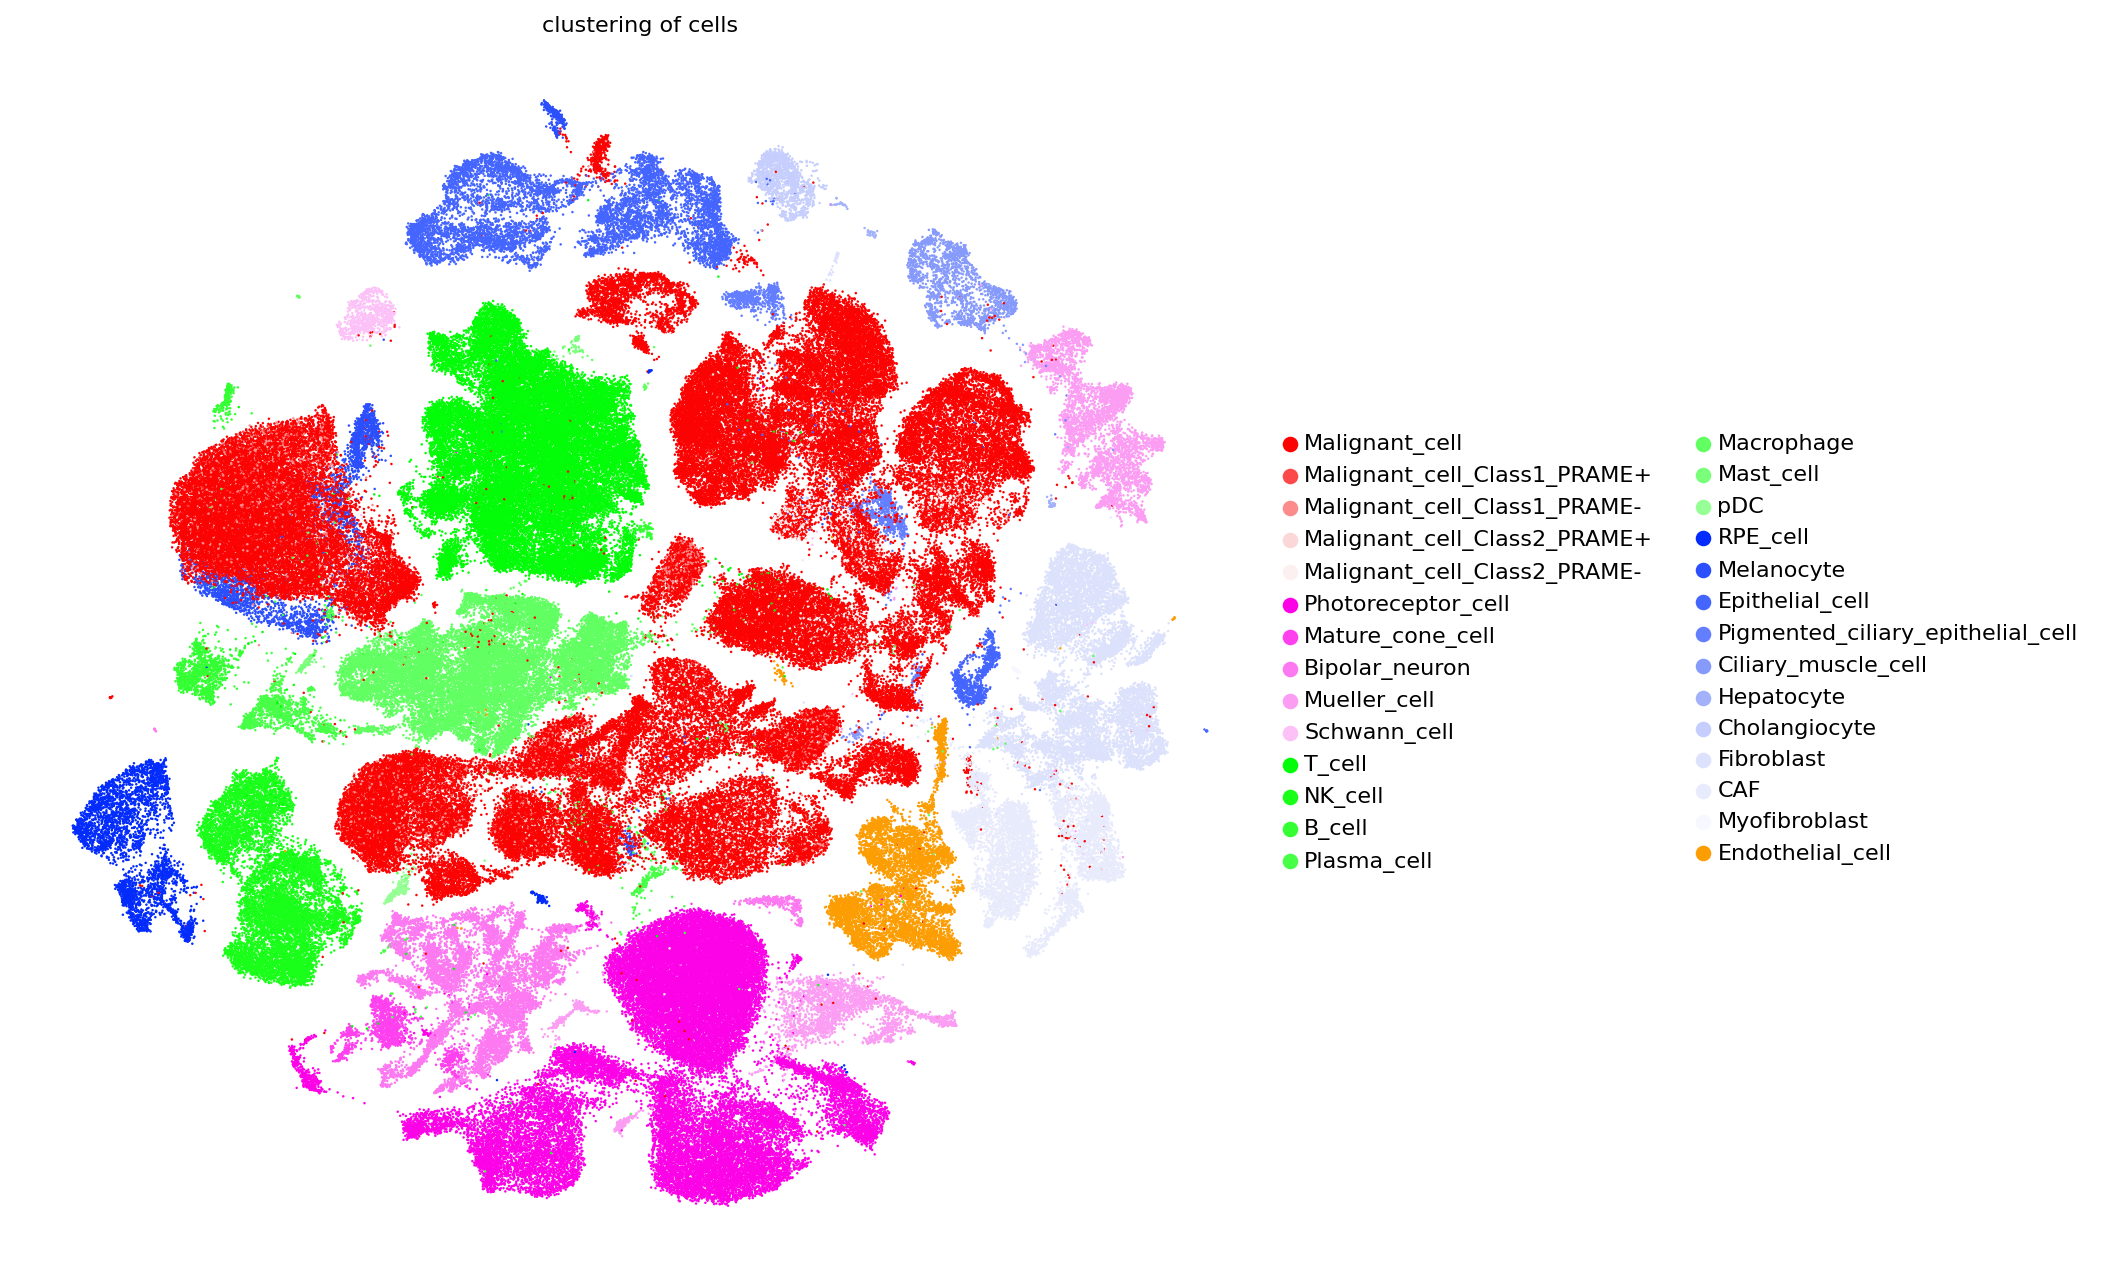

In [30]:
# Inital setting for plot size
from matplotlib import rcParams

FIGSIZE = (10, 10)
rcParams["figure.figsize"] = FIGSIZE

sc.pl.umap(adata, color='malignant_classification',
           legend_fontoutline=5,frameon=False,
           title='clustering of cells', size = 5, add_outline=False, legend_loc= 'right margin', legend_fontsize=10,
palette=[    
    '#fc0303',
    '#fc4a4a',
    '#fc8c8c',
    '#fcd7d7',
    '#fcf0f0',
    
    '#fc03e7',
    '#ff40ef',
    '#fc79f1',
    '#fc9df4',
    '#fcc2f8',
    #'#ffe6fd',
    
    '#03fc07',
    '#19ff19',
    '#33ff33',
    '#47ff47',
    '#61ff61',
    '#7aff7a',
    '#96ff96',
    #'#adffad',
    #'#c4ffc4',
    #'#d7fcd7',
    #'#edffed',
    
    '#032cfc',
    '#2b4ffc',
    '#4565ff',
    '#637eff',
    '#869afc',
    '#a2b1fa',
    '#c5cefc',
    '#dce1fc',
    '#e8ebfc',
    '#f7f8ff',
    
    
    '#fc9d03'
           ],save=True)

/home/jovyan/my-conda-envs/stlearn/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


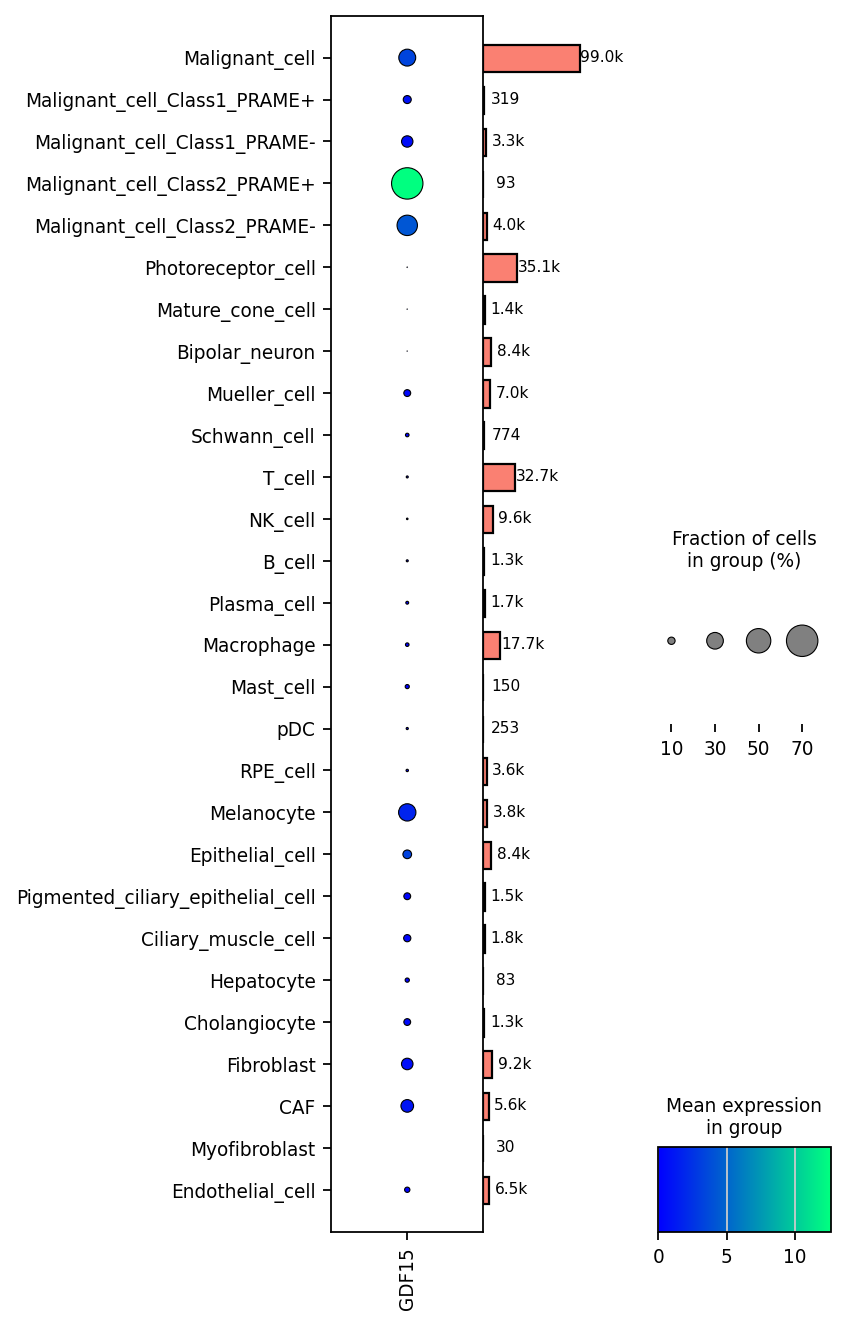

/home/jovyan/my-conda-envs/stlearn/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


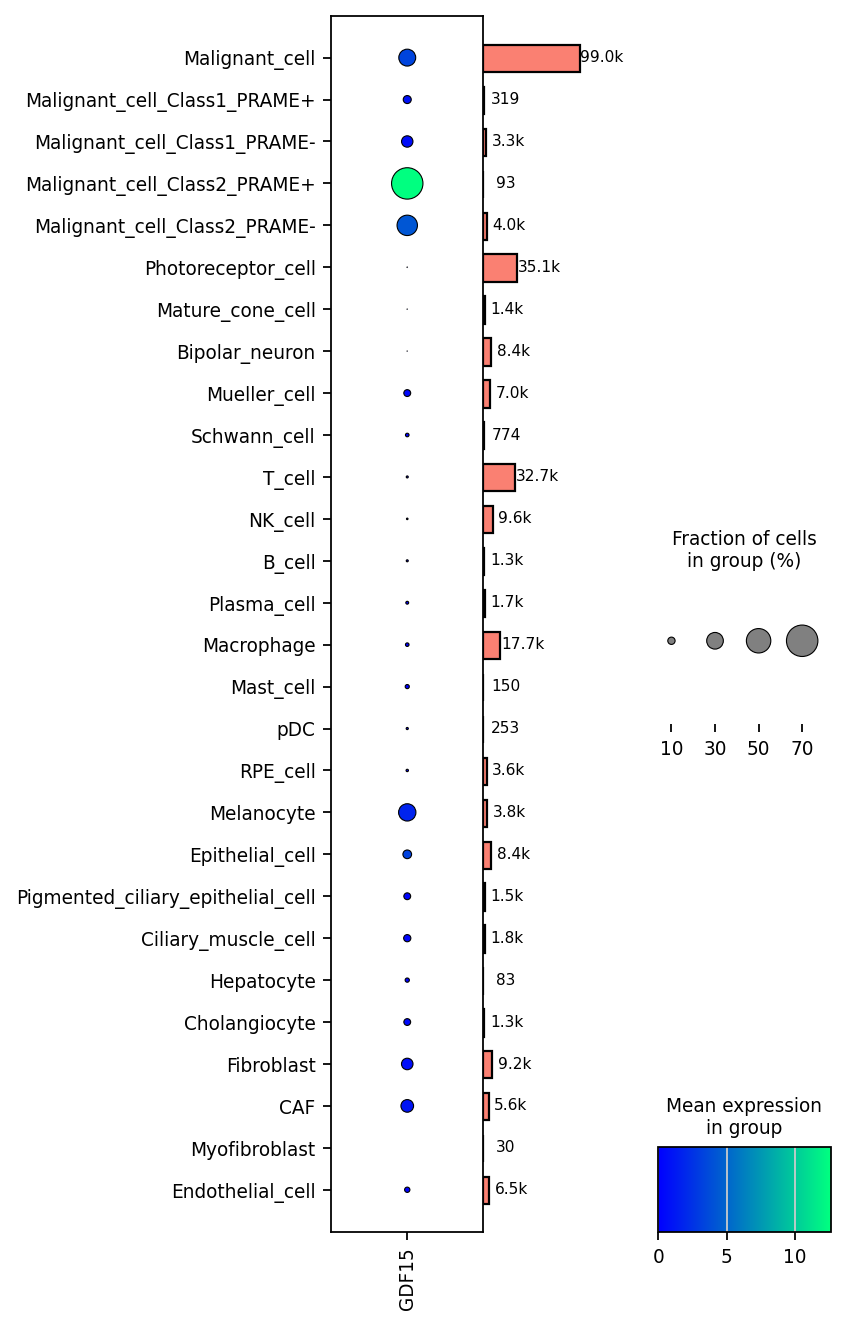

In [31]:
import scanpy as sc

markers = ['GDF15']

# Set figure parameters
sc.set_figure_params(scanpy=True, fontsize=10)

# Generate the dotplot with adjusted figure size and get the figure object
dp = sc.pl.dotplot(adata, markers, 'malignant_classification', figsize=(4,10), return_fig=True)

# Customize the dotplot
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()

# Save the dotplot to a file
#dp.savefig('dotplot.png')  # Save as PNG
dp.savefig('dotplot.pdf')  # Save as PDF (optional)

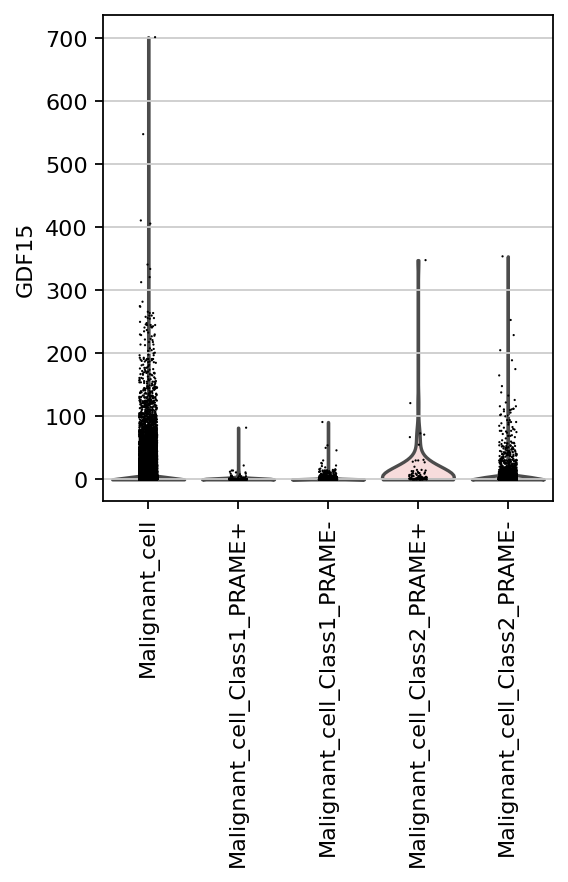

In [32]:
bdata = adata[adata.obs['annotation_level_1'] == 'Malignant_cell']
dp = sc.pl.violin(bdata, markers, 'malignant_classification', figsize=(4,10), return_fig=True, rotation=90, save=True)

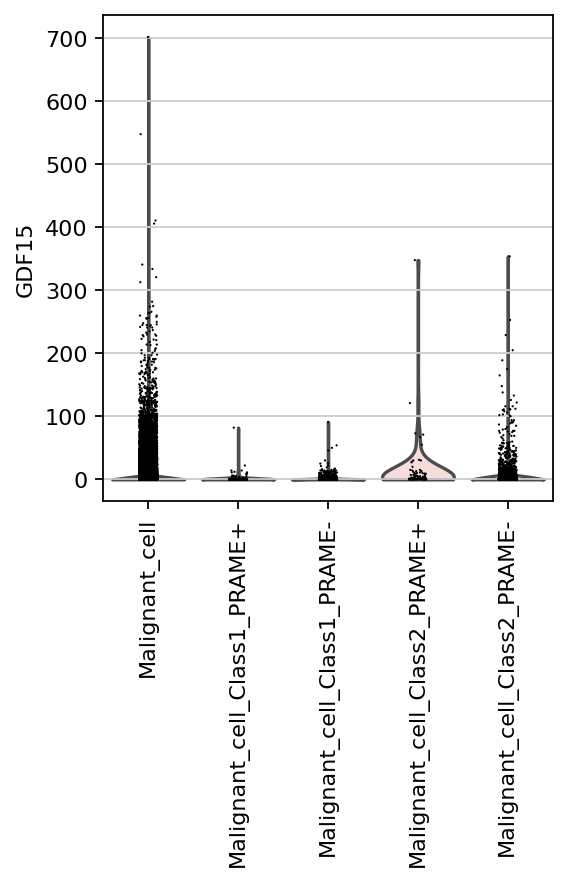

In [33]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

# Create the violin plot and return the figure
dp = sc.pl.violin(bdata, markers, 'malignant_classification', figsize=(4,10), return_fig=True, rotation=90, save=True)

# Get the unique categories for 'malignant_classification'
categories = bdata.obs['malignant_classification'].unique()

# Prepare to compute and store the medians
medians = {}

# Calculate the medians for each category and marker
for marker in markers:
    medians[marker] = {}
    for category in categories:
        # Extract data for this marker and category
        values = bdata[bdata.obs['malignant_classification'] == category].obs_vector(marker)
        
        # Calculate the median
        median_value = np.median(values)
        medians[marker][category] = median_value

# Annotate the plot with median values
if dp is not None:
    # Extract the axes from the returned figure
    axes = dp.axes

    # Add median text below the x-axis for each marker and category
    for i, marker in enumerate(markers):
        ax = axes[i]  # Each axis corresponds to a marker
        
        # Build the text for medians to be printed below the x-axis
        median_text = "\n".join([f"{category}: {medians[marker][category]:.2f}" for category in categories])
        
        # Add the median text below the plot
        ax.text(0.5, -0.15, median_text, transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='center',
                fontsize=10, color='blue')

    # Adjust layout to fit the median annotations
    plt.tight_layout()

    # Show the plot
    plt.show()

In [34]:
medians

{'GDF15': {'Malignant_cell': 0.0,
  'Malignant_cell_Class1_PRAME-': 0.0,
  'Malignant_cell_Class2_PRAME-': 0.0,
  'Malignant_cell_Class1_PRAME+': 0.0,
  'Malignant_cell_Class2_PRAME+': 2.0}}

/home/jovyan/my-conda-envs/stlearn/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


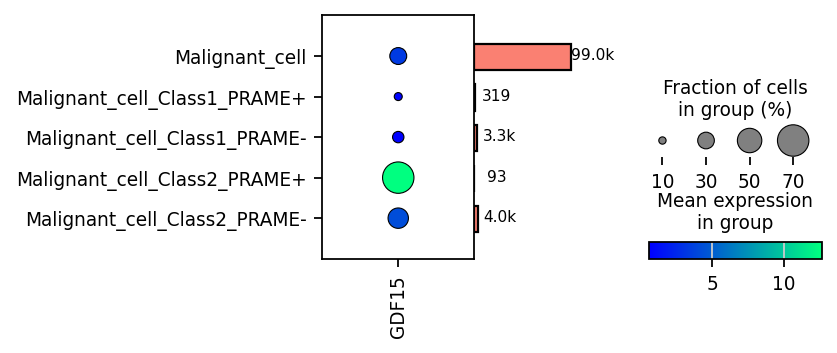

/home/jovyan/my-conda-envs/stlearn/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


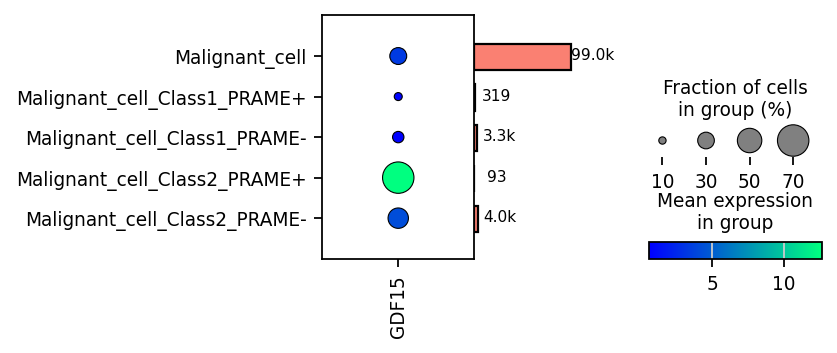

In [35]:
import scanpy as sc

markers = ['GDF15']

# Set figure parameters
sc.set_figure_params(scanpy=True, fontsize=10)

# Generate the dotplot with adjusted figure size and get the figure object
dp = sc.pl.dotplot(bdata, markers, 'malignant_classification', figsize=(4,2), return_fig=True)

# Customize the dotplot
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()

# Save the dotplot to a file
#dp.savefig('dotplot.png')  # Save as PNG
dp.savefig('dotplot.pdf')  # Save as PDF (optional)

In [36]:
import scanpy as sc
import scipy.stats as stats
import matplotlib.pyplot as plt

In [37]:
# Extracting categories for 'malignant_classification'

#dp = sc.pl.violin(bdata, markers, 'malignant_classification', figsize=(4,10), return_fig=True, rotation=90)

categories = bdata.obs['malignant_classification'].unique()

# Calculate p-values between two groups for the given marker
p_values = []
for marker in markers:
    group1 = bdata[bdata.obs['malignant_classification'] == 'Malignant_cell_Class1_PRAME+'].obs_vector(marker)
    group2 = bdata[bdata.obs['malignant_classification'] == 'Malignant_cell_Class1_PRAME-'].obs_vector(marker)
    
    # Perform t-test (or other tests based on your need)
    stat, p_val = stats.ttest_ind(group1, group2)
    p_values.append(p_val)

# You can print or inspect the p-values
print(p_values)

# Calculate p-values between two groups for the given marker
p_values = []
for marker in markers:
    group1 = bdata[bdata.obs['malignant_classification'] == 'Malignant_cell_Class1_PRAME+'].obs_vector(marker)
    group2 = bdata[bdata.obs['malignant_classification'] == 'Malignant_cell_Class2_PRAME+'].obs_vector(marker)
    
    # Perform t-test (or other tests based on your need)
    stat, p_val = stats.ttest_ind(group1, group2)
    p_values.append(p_val)

# You can print or inspect the p-values
print(p_values)

# Calculate p-values between two groups for the given marker
p_values = []
for marker in markers:
    group1 = bdata[bdata.obs['malignant_classification'] == 'Malignant_cell_Class1_PRAME+'].obs_vector(marker)
    group2 = bdata[bdata.obs['malignant_classification'] == 'Malignant_cell_Class2_PRAME-'].obs_vector(marker)
    
    # Perform t-test (or other tests based on your need)
    stat, p_val = stats.ttest_ind(group1, group2)
    p_values.append(p_val)

# You can print or inspect the p-values
print(p_values)

# Calculate p-values between two groups for the given marker
p_values = []
for marker in markers:
    group1 = bdata[bdata.obs['malignant_classification'] == 'Malignant_cell_Class1_PRAME-'].obs_vector(marker)
    group2 = bdata[bdata.obs['malignant_classification'] == 'Malignant_cell_Class2_PRAME+'].obs_vector(marker)
    
    # Perform t-test (or other tests based on your need)
    stat, p_val = stats.ttest_ind(group1, group2)
    p_values.append(p_val)

# You can print or inspect the p-values
print(p_values)

# Calculate p-values between two groups for the given marker
p_values = []
for marker in markers:
    group1 = bdata[bdata.obs['malignant_classification'] == 'Malignant_cell_Class1_PRAME-'].obs_vector(marker)
    group2 = bdata[bdata.obs['malignant_classification'] == 'Malignant_cell_Class2_PRAME-'].obs_vector(marker)
    
    # Perform t-test (or other tests based on your need)
    stat, p_val = stats.ttest_ind(group1, group2)
    p_values.append(p_val)

# You can print or inspect the p-values
print(p_values)

# You can print or inspect the p-values
print(p_values)

# Calculate p-values between two groups for the given marker
p_values = []
for marker in markers:
    group1 = bdata[bdata.obs['malignant_classification'] == 'Malignant_cell_Class2_PRAME+'].obs_vector(marker)
    group2 = bdata[bdata.obs['malignant_classification'] == 'Malignant_cell_Class2_PRAME-'].obs_vector(marker)
    
    # Perform t-test (or other tests based on your need)
    stat, p_val = stats.ttest_ind(group1, group2)
    p_values.append(p_val)

# You can print or inspect the p-values
print(p_values)

[0.38895080208871213]
[3.7486092173029017e-07]
[6.906037291478547e-05]
[8.85548564295825e-55]
[9.889676634682411e-40]
[9.889676634682411e-40]
[1.5496473005361219e-06]
